### Data Set Information:

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. Here you are given a preprocessed version of the data set. Running the code below gives you a subset of images from this data set (200 hundred images of 0s and 200 images of 7s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with open('data_set07.npy','rb') as f:
    data_set=np.load(f)

### the dataset

In [2]:
# understanding the dimensions of the data set
print(np.shape(data_set))


#the first element of the data set has the label of the image
for i in range(0,10):
    print(data_set[i,0])

#we will remove this to visualise the different images (size 28x28)  
X = np.delete(data_set, 0, 1)
[n,p]=np.shape(X)





(400, 785)
7
7
7
0
0
0
7
0
7
0


# visulising the first few images

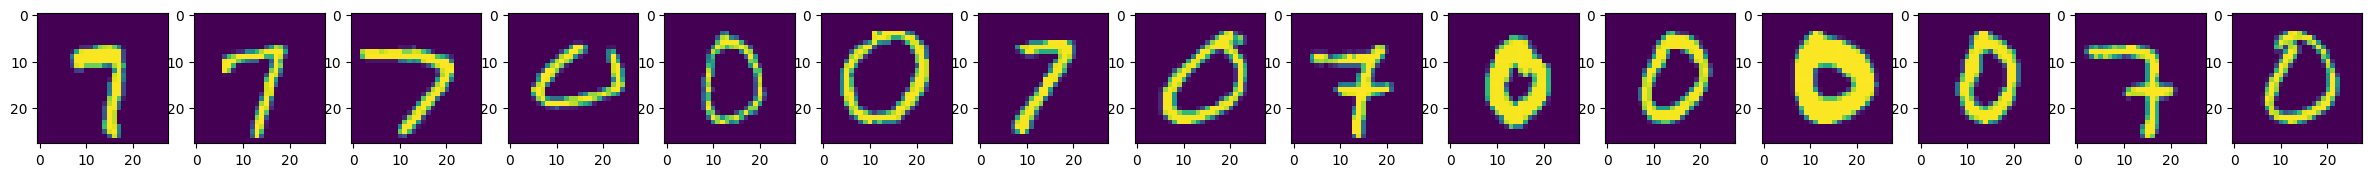

In [3]:
    
# visualising the first few images in the data set
fig,ax = plt.subplots(1,15, figsize=(30, 5))

for i in range(0,15):
    
    ax[i].imshow(X[i,:].reshape(28,28))

## check convergence of K-means clustering algorithm

Convergence reached at iteration 9.


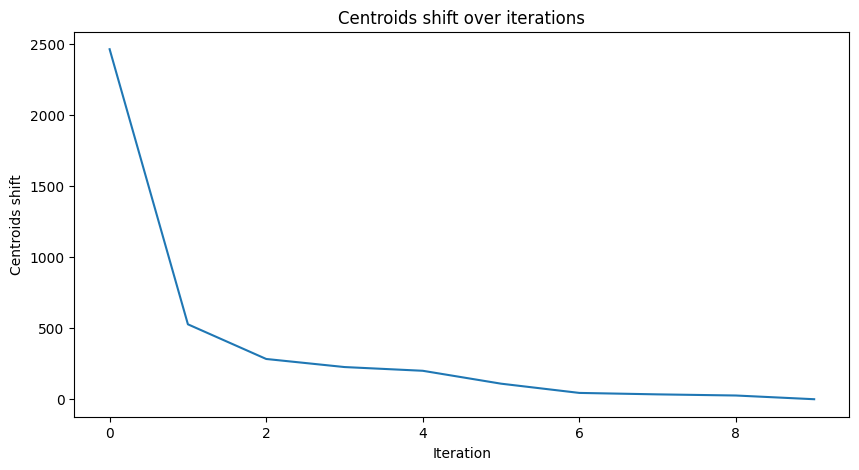

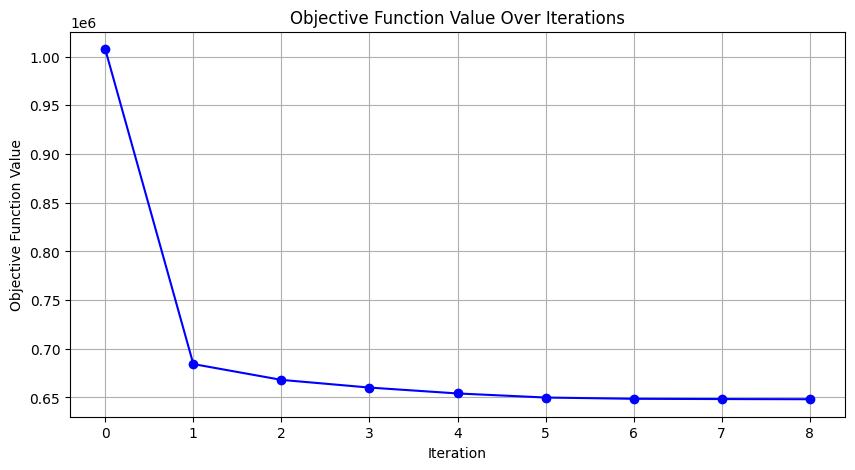

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances, euclidean_distances

np.random.seed(3)

k = 2  ##since data is images of either 7 or 0, we will have 2 clusters in total

##n=400, p = 784 meaning 400 images each with 784 element (28x28 pixels)
I = np.random.permutation(n)  ##randomly order 400 indices
I = I[:k]  # select 2 of them
C = X[I, :]  # initial centroids are the corresponding locations of data points with selected indices


max_iter = 100   ##maximum amount of iterations for k-means
threshold = 1e-8 ##stopping condition
C_prev = np.zeros(C.shape) ##store centroids from previous iteration
centroids_shift = np.zeros(max_iter) ##keeps track of the shifts
func_values = np.zeros(max_iter) ##to store objective function values


for i in range(max_iter):
    D = pairwise_distances(X, C, metric="euclidean")  ###compute pairwise distances to centroid
    yb = np.argmin(D, axis=1) ##find index of closest centroid 
    
    # update centroids
    for l in range(k):
        C_prev[l, :] = C[l, :] #store current centroid position
        C[l, :] = np.mean(X[yb == l, :], axis=0) ##reassign centroids to mean of data points in cluster
    
    # compute the shift in location and check for convergence
    centroids_shift[i] = np.linalg.norm(C - C_prev)
    if centroids_shift[i] < threshold:
        print(f"Convergence reached at iteration {i}.")
        break

    # calculate the objective function for this iteration
    objective_function_value = 0
    for j in range(n):
        objective_function_value += D[j, yb[j]]
    func_values[i] = objective_function_value

plt.figure(figsize=(10, 5))
plt.plot(centroids_shift[:i+1])
plt.title('Centroids shift over iterations')
plt.ylabel('Centroids shift')
plt.xlabel('Iteration')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(func_values[:i], marker='o', linestyle='-', color='b')
plt.title('Objective Function Value Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.show()





### On the first graph, we observe that the centroids changes locations more drastically in initial steps, and then stabilises slowly. Concurrently, the decrease over the objective function is fastest in initial steps as we would expect. By using the convergence threshold of 10^-8 for the norm of the centroid shifts, we see convergence in 9 steps. Note that in different runs, difference convergence numbers can be achieved since the initial centroid location also impacts results. However, the resulting converging value of the objective function is always around 650000 with very small variance, suggesting the centroids converge to similar locations in each run of the algorithm.

## now check how predictions perform

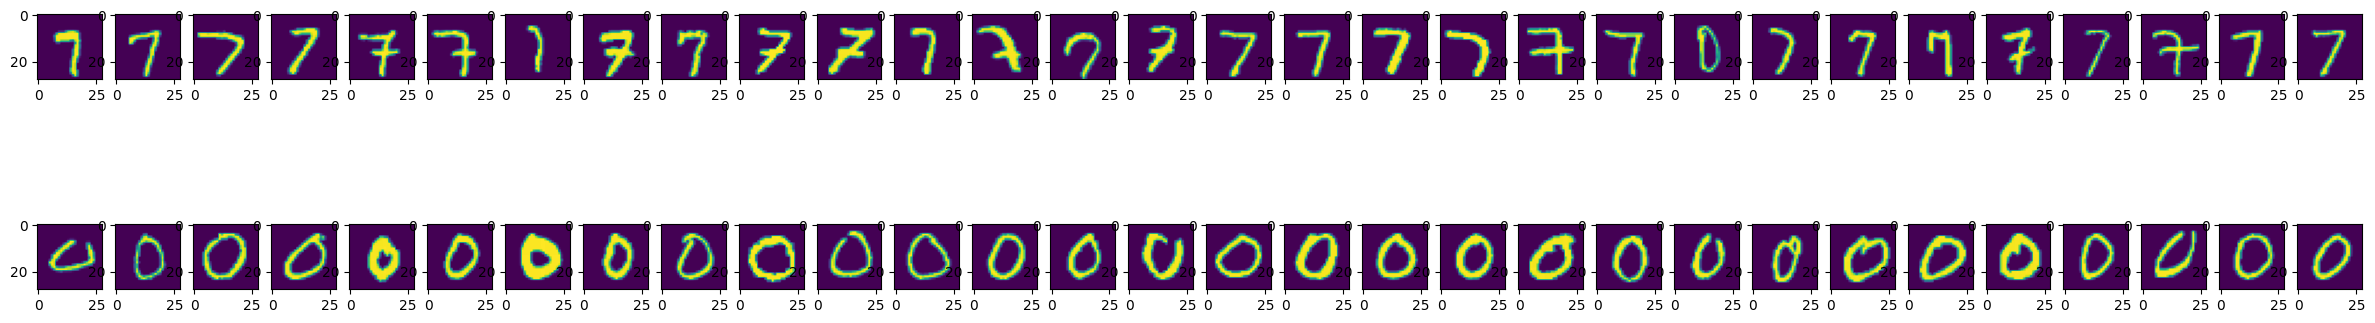

In [5]:
fig,ax = plt.subplots(2,30, figsize=(30, 5))

cluster_0 = X[yb==0, :]
cluster_1 = X[yb==1, :]


for i in range(0,30):
    ax[0,i].imshow(cluster_0[i,:].reshape(28,28))
    ax[1,i].imshow(cluster_1[i,:].reshape(28,28))

### We can visually see that clusters for 7 and 0 obtained by k-means work mostly correct, with a couple of exceptions. In the next section we quantify the accuracy.

## now check accuracies for both clusters

In [6]:

##this is a function I will use in both k-means and spectral clustering parts to measure accuracy
def calculate_cluster_accuracies(cluster_assignments, true_labels):
    cluster_accuracies = {} ##empty dictionary to store accuracies
    cluster_labels = {}
   
   
    for cluster in cluster_assignments:
        labels_in_cluster = true_labels[cluster_assignments == cluster]  ##find true labels of the data points in the current cluster

        most_common_label = np.bincount(labels_in_cluster).argmax() ##find the most common label in the current cluster
         
        correct_predictions = np.sum(labels_in_cluster == most_common_label)  ##find the total number of correct predictions

        accuracy = correct_predictions / labels_in_cluster.size  ##calculate accuracy



        cluster_accuracies[cluster] = accuracy  ##accuracy of the cluster
        cluster_labels[cluster] = most_common_label  # Store the most common label
    return cluster_accuracies, cluster_labels




true_labels = data_set[:, 0]  #true labels of images, either 0 or 7

cluster_accuracies, cluster_labels = calculate_cluster_accuracies(yb, true_labels)

# display accuracies 
for cluster, accuracy in cluster_accuracies.items():
    label = cluster_labels[cluster]
    print(f"Cluster for {label} Accuracy: {accuracy * 100:.2f}%")




Cluster for 7 Accuracy: 96.59%
Cluster for 0 Accuracy: 98.97%


### We see quite high accuracies for both clusters. The accuracies have very small variance across different runs as well, and is not heavily dependent on the initalisation of the centroids for our case. The consistency in the final objective function values mentioned above and clustering accuracies can be beacuse 7's and 0's are well seperated in the MNIST dataset.

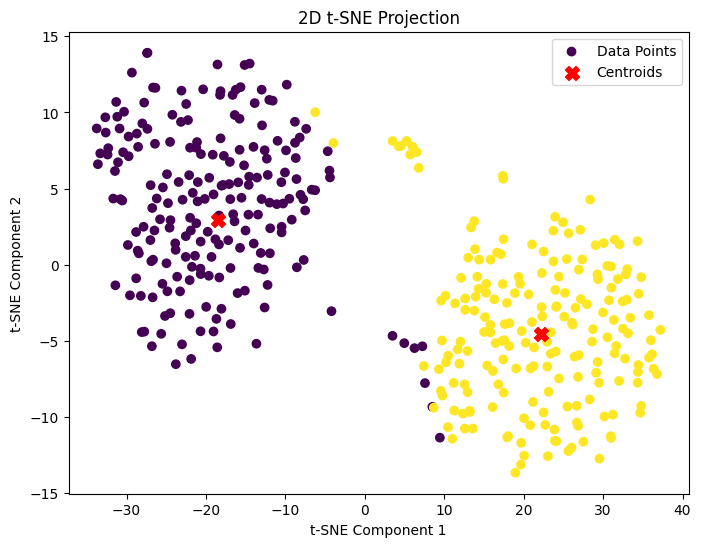

In [8]:
from sklearn.manifold import TSNE
###here I use t-SNE transform

X_combined = np.vstack((X, C))  ###combining data points with centroid locations (to perform dimensionality reduction)

# perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=30)  
X_combined_tsne = tsne.fit_transform(X_combined)  

X_tsne = X_combined_tsne[:-2, :]  #decompose data and centroids for plotting
C_tsne = X_combined_tsne[-2:, :]

# plot data in 2d space
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=yb, cmap='viridis', marker='o', label='Data Points')

# plot centroids in 2d space
plt.scatter(C_tsne[:, 0], C_tsne[:, 1], c='red', marker='X', s=100, label='Centroids')



plt.title('2D t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()  
plt.show()

### In order to better visualise the clustering, a dimension reduction technique such as t-SNE can be applied. Above you can see the resulting clusters with centroids. Note that the axes of this mapping do not have any intuitive meaning as its a result of the merge of dimensions, however t-SNE keeps the similarity between data points when doing so.

# PART 2
We now turn our attention to spectral clustering. We use a fully connected network with weights given by 

$w_{ij}=\exp(-\hat{w}_{ij}/\sigma^{2})$ 

Here $\hat{w}_{ij}$ corresponds to the Euclidean distance between the image i and the image j. 

## We start by plotting the pairwise distance of the first image with every other image on the data set. 


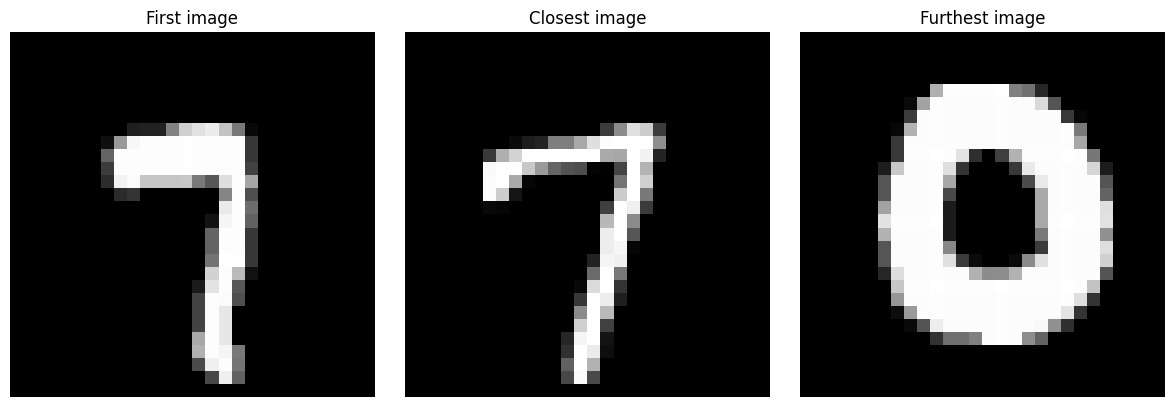

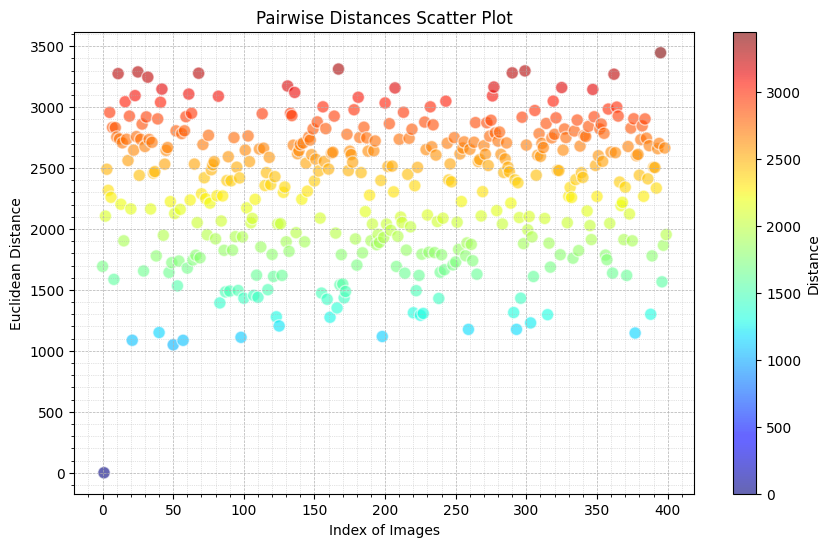

In [10]:
first_image = X[0]  # find first image from the data point
distances_all = euclidean_distances(X, X) ##calculate all distances between data points
distances = distances_all[1, :] ##exclude first image


##finding closest image by distance
closest_image_index = np.argmin(distances)
closest_image = X[closest_image_index]

##finding furthest image by distance
furthest_image_index = np.argmax(distances)
furthest_image = X[furthest_image_index]

# visualising first image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(first_image.reshape(28,28), cmap='gray')
plt.title('First image')
plt.axis('off')

# visualising closest image
plt.subplot(1, 3, 2)
plt.imshow(closest_image.reshape(28, 28), cmap='gray')
plt.title('Closest image')
plt.axis('off')

# visualising furthest image
plt.subplot(1, 3, 3)
plt.imshow(furthest_image.reshape(28, 28), cmap='gray')
plt.title('Furthest image')
plt.axis('off')

plt.tight_layout()
plt.show()

indices = np.arange(len(distances))



## visualising distances of all images to first image
plt.figure(figsize=(10, 6))
plt.scatter(indices, distances, alpha=0.6, edgecolors='w', s=80, c=distances, cmap='jet')
plt.colorbar(label='Distance')
plt.title('Pairwise Distances Scatter Plot')
plt.xlabel('Index of Images')
plt.ylabel('Euclidean Distance')
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.show()


We observe that the first image is a 7, and the closest data point is a very similar 7 only with minor differences in drawing, whereas the most distant one is a 0, not resembling the design of 7. This is expected.

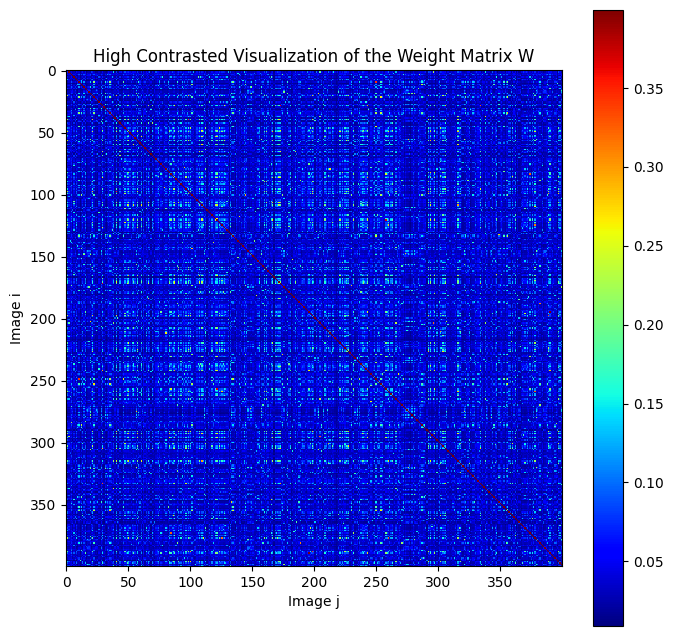

In [11]:
sigma = 28 
sigma_squared = sigma ** 2

W = np.exp(-distances_all / sigma_squared)  ##creating weight matrix

W_no_diagonal = np.copy(W)  ### I will use this matrix to better visualise weights with a heatmap of smaller interval

np.fill_diagonal(W_no_diagonal, np.nan)  ## set diagonal values to NaN since we want to observe a better contrasted heatmap with remaining values and smaller interval

# find the min and max values excluding NaN (diagonal values)
W_min = np.nanmin(W_no_diagonal)
W_max = np.nanmax(W_no_diagonal)


##plotting the contrasted matrix
plt.figure(figsize=(8, 8))
plt.imshow(W, cmap='jet', interpolation='none', vmin=W_min, vmax=W_max)
plt.colorbar()
plt.title('High Contrasted Visualization of the Weight Matrix W')
plt.xlabel('Image j')
plt.ylabel('Image i')
plt.show()


### Here we use a small interval (by exluding the diagonals which are 1) for the heatmap to better see any patterns. We observe some small blocks of similar data types, but this isn't significant. This may be due to how images are grouped in the MNIST dataset. In general we can say no clear pattern. Note how the matrix is symmetric as we would expect. We will see better patterns after reordering.

In [12]:
def GL(x):
    # calculating of the graph Laplacian 
    D=x.sum(axis=0)
    L1=np.diag(D)-x;
    
    return L1

def GL1(x):
    # calculating of the normalised graph Laplacian 
    D=x.sum(axis=0)
    DD=np.diag(D**(-1/2))
    L1=np.eye(len(D))-DD@x@DD
    
    return L1

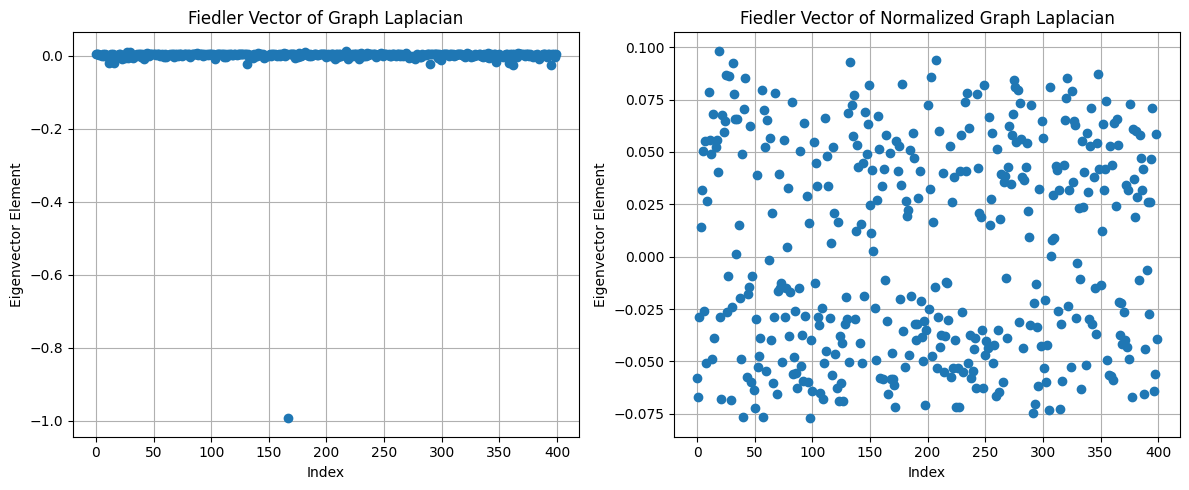

In [13]:
L = GL(W)
L_norm = GL1(W)


##calculating eigenvalues and eigenvectors of both matrices (in increasing order)
eigvals, eigvecs = np.linalg.eigh(L)
eigvals_norm, eigvecs_norm = np.linalg.eigh(L_norm)


##calculating fiedler vectors, which corresponds to second smaller eigenvalue
fiedler_vector = eigvecs[:, 1]
fiedler_vector_norm = eigvecs_norm[:, 1]





plt.figure(figsize=(12, 5))



##plotting
plt.subplot(1, 2, 1)
plt.plot(fiedler_vector, 'o')
plt.title('Fiedler Vector of Graph Laplacian')
plt.xlabel('Index')
plt.ylabel('Eigenvector Element')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fiedler_vector_norm, 'o')
plt.title('Fiedler Vector of Normalized Graph Laplacian')
plt.xlabel('Index')
plt.ylabel('Eigenvector Element')
plt.grid(True)

plt.tight_layout()
plt.show()

### We use fiedler vector as it better captures the spectral clustering structure, since the eigenvector corresponding to smallest eigenvalue is a constant vector and can not provide a meaningful insight about the network structure.

### The unnormalised Fiedler vector has most elements close to 0 and only one close to the value 1. For the normalised case, we see that the elements look evenly spread in a quite small interval. In the normalised Laplacian, each element of the vector is influenced by the degree of the corresponding node, which can provide a balanced view of the network structure. However we see that the 2 clusters are now better distiunguishable (positive and negative elements). Overall, using the normalised case for sprectral clustering will be beneficial.

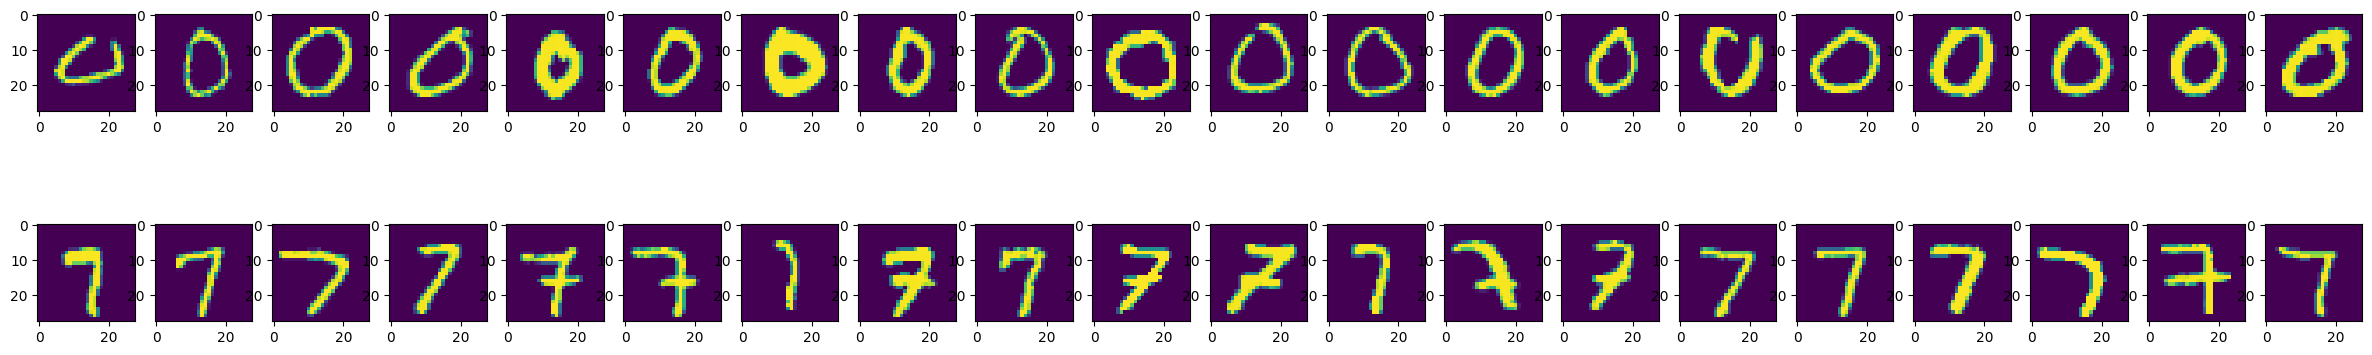

In [14]:

# spectral clustering using the normalised vector
m_norm = np.sign(fiedler_vector_norm)
I1 = np.nonzero(m_norm > 0) # cluster assignment for 0's
I2 = np.nonzero(m_norm < 0) # cluster assignment for 7's

fig,ax = plt.subplots(2,20, figsize=(30, 5))

for i in range(0,20):
    ax[0,i].imshow(X[I1[0][i],:].reshape(28,28))
    ax[1,i].imshow(X[I2[0][i],:].reshape(28,28))

### We see that spectral clustering works as well, with correct clusters for 0's and 7's. Next, we visually see clusters by mapping to 2d space with t-SNE technique as before.

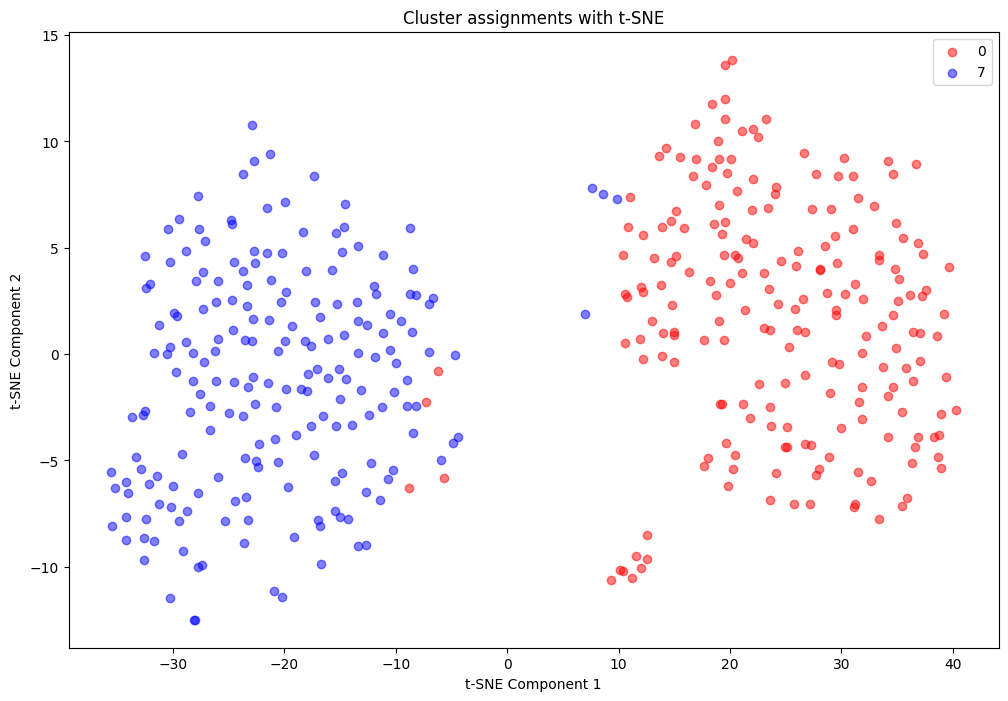

In [16]:
##transforming to 2d
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(data_set[:, 1:]) 

# plotting
plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[I1, 0], X_embedded[I1, 1], c='red', label='0', alpha=0.5)
plt.scatter(X_embedded[I2, 0], X_embedded[I2, 1], c='blue', label='7', alpha=0.5)
plt.legend()
plt.title('Cluster assignments with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Visually, we see that clustering is successful. Next we measure accuracies.

In [28]:
cluster_accuracies = calculate_cluster_accuracies(m_norm, true_labels)  ###use the function we have defined before for k-means part

cluster_accuracies



({-1.0: 0.9849246231155779, 1.0: 0.9800995024875622}, {-1.0: 7, 1.0: 0})

## We see that both clusters have around 98 percent accuracy (Cluster -1 corresponding to 7's, 1 corresponding to 0's). So the method is quite accurate. High accuracies of both k-means and spectral clustering methods can be due to both 0's and 7's being sufficiently distinct in high dimensional space.

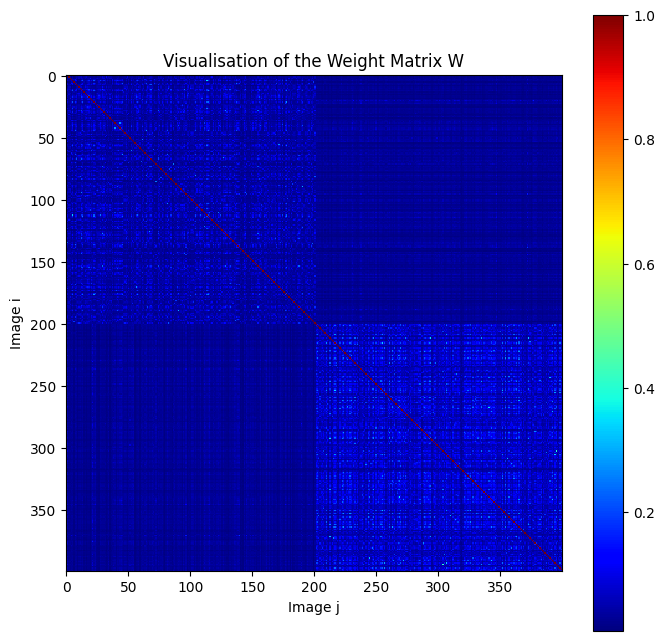

In [31]:
## reordering 
new_order = np.concatenate((I1[0], I2[0]))


##creating the reordered matrix
W_reordered = W[new_order, :][:, new_order]


## finding minimum and maximum points again 
W_min = np.nanmin(W_reordered)
W_max = np.nanmax(W_reordered)

# plotting
plt.figure(figsize=(8, 8))
plt.imshow(W_reordered, cmap='jet', interpolation='none', vmin=W_min, vmax=W_max)
plt.colorbar()
plt.title('Visualisation of the Weight Matrix W')
plt.xlabel('Image j')
plt.ylabel('Image i')
plt.show()



## Now we see a clear block structure of similar data points. This indicates that images within the same cluster have higher pairwise similarity scores compared to images from different clusters. We see blocks of similar size, meaning the clusters are of equal size. The blocks corresponding to top left and bottom right suggest that those data points are similar. The darker blocks outside these diagonal blocks suggest dissimilarity.